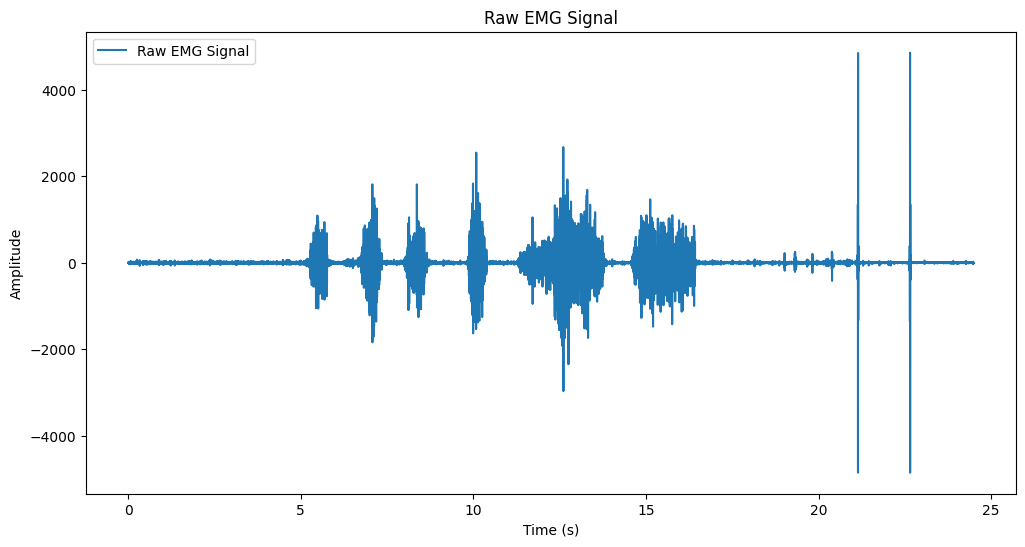

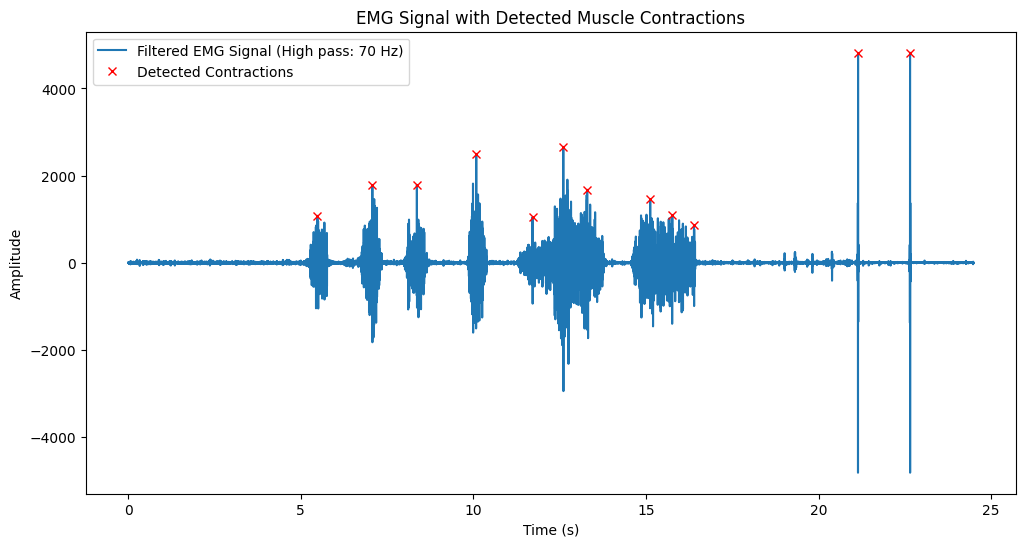

Feature Summary:
       mean_absolute_value  root_mean_square  waveform_length  mean_frequency  \
count            25.000000         25.000000        25.000000       25.000000   
mean             96.578105        183.435464     74343.161686      152.600041   
std             113.571076        171.688639     87256.509892       14.979306   
min               3.763660          6.057254      1972.725906      129.874154   
25%              11.503070         15.612007      9613.897178      142.003433   
50%              36.917191        197.359688     32034.134905      153.454531   
75%             157.396512        320.392026    114919.294206      166.456741   
max             436.830341        599.493702    339133.428122      177.784696   

       median_frequency  zero_crossing_rate  autocorrelation  
count         25.000000           25.000000        25.000000  
mean         146.718750            0.598681        -0.278851  
std           18.702468            0.039680         0.152830  
m

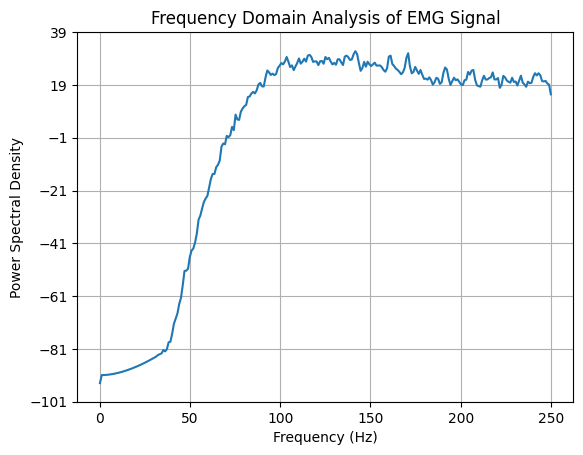

In [ ]:
# Import necessary libraries for data manipulation, signal processing, and visualization
import pandas as pd
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks, butter, filtfilt

# Load and Clean the EMG Data
csv_file = 'emg_sample.csv'
emg_data = pd.read_csv(csv_file)  # Read the EMG data from CSV
emg_signal = nk.emg_clean(emg_data['Channel1'], sampling_rate=500)  # Clean the raw EMG signal using NeuroKit2's cleaning function

# Define a time array for plotting
time = np.arange(len(emg_signal)) / 500  # Create a time array (in seconds)

# Apply a High-Pass Filter at 70 Hz
def highpass_filter(signal, cutoff=70, fs=500, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filter the cleaned EMG signal with a high-pass filter
emg_filtered = highpass_filter(emg_signal, cutoff=70, fs=500)

# Detect Muscle Contractions Using Peaks
# Set threshold based on signal mean and standard deviation for significant peaks
threshold = np.mean(emg_filtered) + 1.5 * np.std(emg_filtered)
peaks, _ = find_peaks(emg_filtered, height=threshold, distance=250)  # Ensure peaks are separated by at least 250 ms

# Plot Raw EMG Signal
plt.figure(figsize=(12, 6))
plt.plot(time, emg_signal, label='Raw EMG Signal')
plt.title('Raw EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot Filtered EMG Signal with Detected Muscle Contractions
plt.figure(figsize=(12, 6))
plt.plot(time, emg_filtered, label='Filtered EMG Signal (High pass: 70 Hz)')
plt.plot(time[peaks], emg_filtered[peaks], 'rx', label='Detected Contractions')
plt.title('EMG Signal with Detected Muscle Contractions')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
# Feature Extraction Function
def extract_emg_features(segment):
    """
    Extracts statistical features from an EMG segment: Mean Absolute Value (MAV),
    Root Mean Square (RMS), and Waveform Length (WL).
    """
    features = {
        'mean_absolute_value': np.mean(np.abs(segment)),  # reflecting muscle contraction intensity
        'root_mean_square': np.sqrt(np.mean(segment**2)),  # indicating muscle force.
        'waveform_length': np.sum(np.abs(np.diff(segment))),  # providing insights of muscle activity duration & intensity.
    }
    return features

# Additional Feature Extraction Techniques
def extract_frequency_features(segment, fs=500):
    """
    Extracts frequency-domain features: Mean Frequency (MNF) and Median Frequency (MDF).
    """
    f, Pxx = welch(segment, fs, nperseg=128)  # Adjusted nperseg to handle small segments
    mnf = np.sum(f * Pxx) / np.sum(Pxx)  # Mean Frequency (MNF) - indicates muscle fatigue
    mdf = f[np.cumsum(Pxx) >= np.sum(Pxx) / 2][0]  # Median Frequency (MDF) - distinguishes contraction types
    return mnf, mdf

def zero_crossing_rate(segment):
    """
    Calculates the Zero Crossing Rate, which is useful to measure signal complexity.
    """
    return np.sum(np.diff(np.sign(segment)) != 0) / len(segment)  # Measures the number of times the signal crosses zero
    # Which indicates signal smoothness and contraction consistency.

def autocorrelation(segment):
    """
    Calculates the autocorrelation of the EMG segment.
    """
    return np.corrcoef(segment[:-1], segment[1:])[0, 1]  # Measures how much the signal correlates with itself

# Segment the EMG Signal and Extract Features
window_size = 500  # 1-second window as the sampling rate is 500 Hz
# Split the EMG signal into 1-second segments (500 samples per segment)
segmented_emg = [emg_filtered[i:i + window_size] for i in range(0, len(emg_filtered), window_size)]
features = []  # Initialize an empty list to store extracted features

# Loop through each segment and extract features
for segment in segmented_emg:
    # Extract time-domain features (MAV, RMS, WL)
    emg_features = extract_emg_features(segment)
    # Extract frequency-domain features (MNF, MDF)
    mnf, mdf = extract_frequency_features(segment)
    # Compute Zero Crossing Rate and Autocorrelation
    zcr = zero_crossing_rate(segment)
    acf = autocorrelation(segment)
    
    # Combine all features into a dictionary
    emg_features.update({
        'mean_frequency': mnf,
        'median_frequency': mdf,
        'zero_crossing_rate': zcr,
        'autocorrelation': acf
    })
    
    # Add the features dictionary to the list
    features.append(emg_features)

# Convert features to a DataFrame for easier analysis
features_df = pd.DataFrame(features)

# Summary of Features
print("Feature Summary:")
print(features_df.describe())  # Display basic statistics of the extracted features

# Frequency Domain Analysis (FFT)
def plot_frequency_domain(emg_signal, fs=500):
    """
    Performs Fast Fourier Transform (FFT) and plots the frequency components of the EMG signal.
    """
    # Use the Power Spectral Density (PSD) plot to visualize frequency content of the signal
    f, Pxx = plt.psd(emg_signal, NFFT=512, Fs=fs)  # NFFT specifies the number of points for FFT
    plt.title('Frequency Domain Analysis of EMG Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.show()  # Display the plot

plot_frequency_domain(emg_filtered)  # Perform FFT and plot the frequency domain of the filtered signal